# Test latent same-gender dimension
Let's try (1) embedding the same-gender and diff-gender sentences in the same space; (2) compressing the embeddings to 2 dimensions; (3) visualizing differences.

In [5]:
## load relationship data 
import pandas as pd
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import load_clean_relationship_sent_data
relationship_sent_data = load_clean_relationship_sent_data()

In [2]:
## sentence encoder
from sentence_transformers import SentenceTransformer
sentence_embed_model = SentenceTransformer(model_name_or_path='distiluse-base-multilingual-cased-v1')

  0%|          | 0.00/505M [00:00<?, ?B/s]

In [9]:
## embed all sentences
relationship_sent_data_embeds = sentence_embed_model.encode(relationship_sent_data.loc[:, 'sent'].values, show_progress_bar=True)
## attach to data
relationship_sent_data = relationship_sent_data.assign(**{
    'sent_embed' : [relationship_sent_data_embeds[i, :] for i in range(len(relationship_sent_data_embeds))]
})

Batches:   0%|          | 0/270 [00:00<?, ?it/s]

In [10]:
## write to file, restart kernel to save GPU space
relationship_sent_data.loc[:, ['sent', 'sent_embed']].to_csv('data/relationship_sent_embeds.gz', sep='\t', compression='gzip', index=False)

In [1]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import str2array, load_clean_relationship_sent_data
import pandas as pd
relationship_sent_embed_data = pd.read_csv('data/relationship_sent_embeds.gz', sep='\t', compression='gzip', converters={'sent_embed' : str2array})
relationship_sent_data = load_clean_relationship_sent_data()
relationship_sent_data = pd.merge(relationship_sent_data, relationship_sent_embed_data,
                                  on='sent', how='inner')

First test: are the same-diff dimensions roughly in the same direction?

In [51]:
## align same/diff sentences
paired_sent_embeds = pd.pivot(relationship_sent_data, index=['lang', 'relationship_topic', 'relationship_word_category', 'subject_word_en', 'subject_gender'], columns=['relationship_type'], values=['sent_embed', 'sent']).reset_index()
# collapse columns
paired_sent_embeds.columns = paired_sent_embeds.columns.map(lambda x: '_'.join(x) if x[1] != '' else x[0])
# compute embed diffs
paired_sent_embeds = paired_sent_embeds.assign(**{
    'sent_embed_diff' : paired_sent_embeds.apply(lambda x: x.loc['sent_embed_diff_gender'] - x.loc['sent_embed_same_gender'], axis=1)
})
display(paired_sent_embeds.head())
# compute variance for differences in paired sentences and in randomly-paired sentences
paired_sent_diff_var = np.vstack(paired_sent_embeds.loc[:, 'sent_embed_diff']).var(axis=0)
N_embeds = paired_sent_embeds.shape[0]
random_pair_sent_embed_diffs = (np.vstack(paired_sent_embeds.loc[:, 'sent_embed_diff_gender'].sample(N_embeds, replace=False, random_state=123)) - 
                                np.vstack(paired_sent_embeds.loc[:, 'sent_embed_same_gender'].sample(N_embeds, replace=False, random_state=456)))
random_pair_sent_embed_diff_var = random_pair_sent_embed_diffs.var(axis=0)
# significance test
from scipy.stats import ttest_rel
mean_var_diff = (paired_sent_diff_var - random_pair_sent_embed_diff_var).mean()
test_stat, p_val = ttest_rel(paired_sent_diff_var, random_pair_sent_embed_diff_var)
print(f'mean diff in variance = {mean_var_diff:.3E} (t={test_stat:.3f}, p={p_val:.3E})')

mean diff in variance = -1.776E-03 (t=-39.276, p=1.835E-156)


In [55]:
relationship_sent_embeds.shape

(8640,)

In [57]:
## compress sent embed to 2 dimensions
from sklearn.decomposition import PCA
import numpy as np
pca_model = PCA(n_components=2)
paired_sent_embeds_diff_gender = np.vstack(paired_sent_embeds.loc[:, 'sent_embed_diff_gender'].values)
paired_sent_embeds_same_gender = np.vstack(paired_sent_embeds.loc[:, 'sent_embed_same_gender'].values)
relationship_sent_embeds = np.vstack([
    paired_sent_embeds_diff_gender, paired_sent_embeds_same_gender
])
pca_model.fit(relationship_sent_embeds)
print(pca_model.explained_variance_)
compress_embeds_diff_gender = pca_model.transform(paired_sent_embeds_diff_gender)
compress_embeds_same_gender = pca_model.transform(paired_sent_embeds_same_gender)
paired_sent_embeds = paired_sent_embeds.assign(**{
    'compress_sent_embed_diff_gender' : [compress_embeds_diff_gender[i, :] for i in range(len(compress_embeds_diff_gender))],
    'compress_sent_embed_same_gender' : [compress_embeds_same_gender[i, :] for i in range(len(compress_embeds_same_gender))],
})
display(paired_sent_embeds.loc[:, ['compress_sent_embed_diff_gender', 'compress_sent_embed_same_gender']].head())
# convert to plottable data

[0.06737424 0.04684503]


,compress_sent_embed_diff_gender,compress_sent_embed_same_gender
0,"[-0.18403462108787177, -0.046103691918204605]","[-0.1798408134167368, -0.024889642137044074]"
1,"[-0.1747610290135953, -0.03341213703925803]","[-0.1734917695115534, -0.05401654823915407]"
2,"[-0.16347604324477433, -0.06098798391506011]","[-0.15662476474517628, -0.044512781869166906]"
3,"[-0.1495024115723233, -0.05276384509512945]","[-0.15227970206579194, -0.06857537979474057]"
4,"[-0.18792704139529193, -0.024008055208946]","[-0.17890838437034806, -0.009743922155850723]"


In [62]:
# convert to plot-table data
id_vars = ['lang', 'relationship_topic', 'relationship_word_category', 'subject_word_en', 'subject_gender']
flat_paired_sent_embeds = paired_sent_embeds.melt(id_vars=id_vars, value_vars=['compress_sent_embed_diff_gender', 'compress_sent_embed_same_gender'], value_name='embed', var_name='sent_type')
flat_paired_sent_embeds = flat_paired_sent_embeds.assign(**{
    'embed_x' : flat_paired_sent_embeds.loc[:, 'embed'].apply(lambda x: x[0]),
    'embed_y' : flat_paired_sent_embeds.loc[:, 'embed'].apply(lambda x: x[1]),
    'relationship_type' : flat_paired_sent_embeds.loc[:, 'sent_type'].apply(lambda x: '_'.join(x.split('_')[-2:]))
})
display(flat_paired_sent_embeds.head())

,lang,relationship_topic,relationship_word_category,subject_word_en,subject_gender,sent_type,embed,embed_x,embed_y,relationship_type
0,en,date,ENGAGE,analyst,female,compress_sent_embed_diff_gender,"[-0.18403462108787177, -0.046103691918204605]",-0.184035,-0.046104,diff_gender
1,en,date,ENGAGE,analyst,male,compress_sent_embed_diff_gender,"[-0.1747610290135953, -0.03341213703925803]",-0.174761,-0.033412,diff_gender
2,en,date,ENGAGE,artist,female,compress_sent_embed_diff_gender,"[-0.16347604324477433, -0.06098798391506011]",-0.163476,-0.060988,diff_gender
3,en,date,ENGAGE,artist,male,compress_sent_embed_diff_gender,"[-0.1495024115723233, -0.05276384509512945]",-0.149502,-0.052764,diff_gender
4,en,date,ENGAGE,athlete,female,compress_sent_embed_diff_gender,"[-0.18792704139529193, -0.024008055208946]",-0.187927,-0.024008,diff_gender


Now! Let's plot these points on the same axis and see what the distribution looks like.

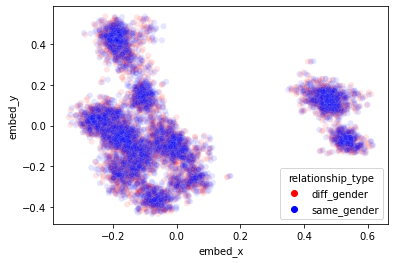

In [71]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(data=flat_paired_sent_embeds, x='embed_x', y='embed_y', hue='relationship_type', alpha=0.1, palette=['r', 'b'])
plt.show()

This is a little hard to interpret but basically looks like noise. 

Let's zoom in on specific examples and see if there are consistencies in differences (e.g. all sentences with `painter` and `spouse` as source and target).

In [72]:
print(flat_paired_sent_embeds.loc[:, 'subject_word_en'].sort_values().unique())

['analyst' 'artist' 'athlete' 'author' 'baker' 'banker' 'barber' 'boss'
 'carpenter' 'coach' 'consultant' 'cop' 'counselor' 'custodian' 'dancer'
 'dentist' 'director' 'doctor' 'editor' 'electrician' 'engineer'
 'entertainer' 'entrepreneur' 'farmer' 'firefighter' 'journalist' 'judge'
 'laborer' 'landlord' 'lawyer' 'librarian' 'mechanic' 'nanny' 'nurse'
 'painter' 'pharmacist' 'photographer' 'plumber' 'president' 'professor'
 'psychologist' 'realtor' 'scientist' 'secretary' 'senator' 'singer'
 'student' 'surgeon' 'teacher' 'writer']


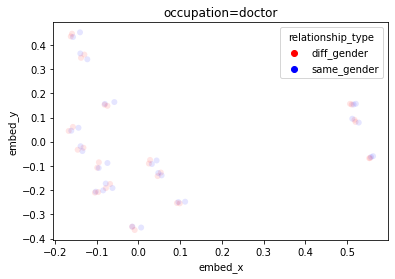

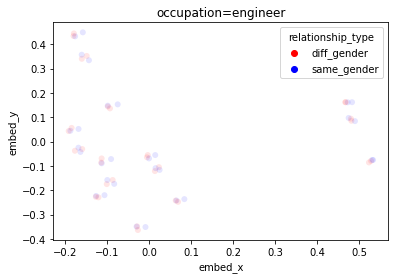

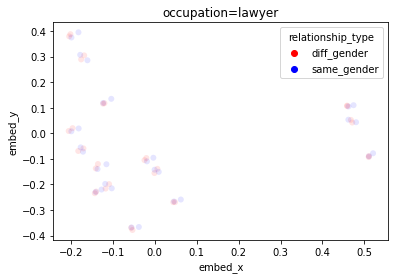

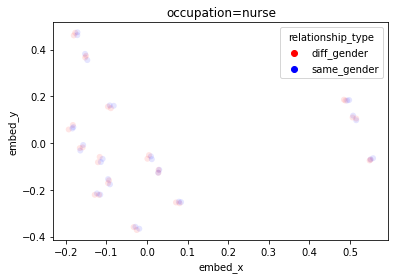

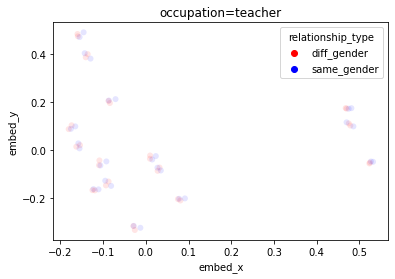

In [75]:
sample_occupation_words = ['doctor', 'engineer', 'lawyer', 'nurse', 'teacher']
sample_langs = ['en']
for w_i in sample_occupation_words:
    data_i = flat_paired_sent_embeds[(flat_paired_sent_embeds.loc[:, 'subject_word_en']==w_i)&
                                     (flat_paired_sent_embeds.loc[:, 'lang'].isin(sample_langs))]
    sns.scatterplot(data=data_i, x='embed_x', y='embed_y', hue='relationship_type', alpha=0.1, palette=['r', 'b'])
    plt.title(f'occupation={w_i}')
    plt.show()

Unfortunately it looks like we don't have a strong story here about a latent "same gender" dimension.

Next: let's try to compute the average same-gender projection in the same way that prior work has used the (he-she) distinction, and then project the sentences to find sentences that are especially indicative of same-gender relationships. This will definitely work and not blow up in our face at all.

In [ ]:
## TODO: sent*(same_gender - diff_gender) => sort along resulting dimension
## TODO: control for male/female?? idk